# Small conductance based network

In this project, we aim at simulating a small (two-neuron) network formed by identical conductance-
based neuron models, with the following structure:
- Neuron 1 receives a Poisson input at ν Hz through synapses modulated by an α function.
- Neuron 1 excites Neuron 2 through a graded synapsis.
- Neuron 2 inhibits Neuron 1 through a graded synapsis.

In the last part of the project, we will study the effect of plasticity (facilitation and depression).



**1-Simulate an input Poisson train for 1 second with rate $ν = 50Hz$**. 

For the homogeneous Poisson process we have $P\,[\text{ 1 spike during } \delta t]=r\delta t$ where $r$ is the input rate. This equation can be used to generate a Poisson  spike train $\{t_j\}_{j=1}^{n_{spk}}$ by first subdividing time into short intervals, each of duration $\delta t$. Then, generate a sequence of random numbers $x[i]$, uniformly distributed between 0 and 1. For each $\delta t$-interval, if $x[i] ≤ r∆t$, generate a spike. Otherwise, no spike is generated. This procedure is appropriate only when $\delta t$ is very small, i.e, only when $r\delta t$ << 1. Typically, ${\delta t}$ = 0.1 msec should suffice. 

For more information, see these notes by David Heeger (NYU).

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math as mth

Simple run

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


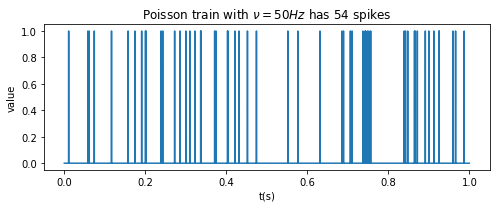

In [2]:
dt = 0.0001 # dt = 0.1msec
t = np.arange(0.0, 1.0, dt)
rate = 50

spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
spikes = spikes.astype(int)

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(t, spikes)
ax.set(title=f"Poisson train with $ν = 50Hz$ has {np.sum(spikes)} spikes",
       xlabel="t(s)",
       ylabel="value")
fig.tight_layout()
fig.show()

Number of spikes histogram

In [3]:
dt = 0.0001 # dt = 0.1msec
t = np.arange(0.0, 1.0, dt)
rate = 50

n_runs = 10000
results = np.zeros(n_runs)
for i in range(n_runs):
    spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
    spikes = spikes.astype(int)
    results[i] = np.sum(spikes)
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


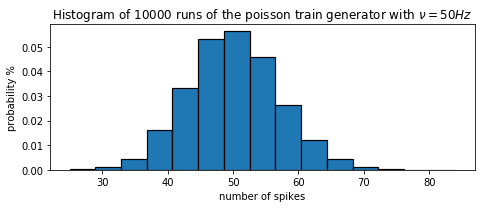

In [4]:
fig, ax = plt.subplots(figsize=(7,3))
ax.hist(results,15,density=True,edgecolor='black', linewidth=1.2)
ax.set(title=f"Histogram of {n_runs} runs of the poisson train generator with $ν = 50Hz$",
       xlabel="number of spikes",
       ylabel="probability %")
fig.tight_layout()
fig.show()

Time between spikes histogram

In [5]:
dt = 0.0001 # dt = 0.1 msec
t = np.arange(0.0, 1.0, dt)
rate = 50

n_runs = 100
intervals = []
for i in range(n_runs):
    spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
    index = np.where(spikes)[0]
    intervals.append(index[1:]-index[:-1])
    
intervals = np.concatenate(intervals).ravel()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


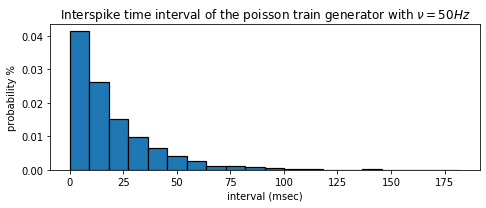

In [6]:
fig, ax = plt.subplots(figsize=(7,3))
ax.hist(intervals*0.1,20,density=True,edgecolor='black', linewidth=1.2)
ax.set(title=f"Interspike time interval of the poisson train generator with $ν = 50Hz$",
       xlabel="interval (msec)",
       ylabel="probability %")
fig.tight_layout()
fig.show()

In [7]:
def spike_train(d, rate, dt):
    """ Generates Poisson delta train
    Params:
    d (int): duration in second of the train
    rate (int): how many firings per second (Hz)
    dt (float): time differential used in the simulation
    Returns:
    result (np.array) with the indexes of the spikes
    """
    # As the standard dt is 1ms and this is not enough for this method to
    # give accurate results I add a reduction factor to spike generation
    reduction = 10   
    
    n = int(d/dt*reduction)
    
    spikes = np.random.rand(n) < rate*d*dt/reduction
    
    index = np.where(spikes)[0]
    
    return index/reduction

**2-Study of the post-synaptic potentials induced by the Poisson train.**

From the spike train obtained in (1), generate a synaptic input $g_{syn}(t) = \hat{g}\sum_j\alpha(t-t_j)H(t-t_j)$ where $\alpha (t) = 1/\tau_{s}^{2}t\text{exp}(-t/\tau_{s})$ and $H$ is the Heaviside function. Inject it into the system (you can try to inject the first only):

$$CV' = I - g_L(V-E_L)-g_{Na}m_{\infty}(V)(V-E_{Na})-g_Kn(V-E_K)+g_{syn}(t)(V-E_{syn})$$
$$\tau_nn = n_{\infty}(V)-n$$

with
$$m_{\infty}(V) = 1./(1.+exp(-(V-V_{max,m})/k_m))$$
and
$$n_{\infty}(V) = 1./(1.+exp(-(V-V_{max,n})/k_n))$$

In [8]:
# global model variables
ena, ek, el, esyn = 60, -90, -80, -30 #which gk is right?
gna, gk, gl = 20, 10, 8 
C, I = 1, 0
vmaxm, vmaxn = -20, -25
km, kn = 15, 5
taun, taus = 1, 5 

Synaptic excitation function

In [9]:
def alfa(t):
    return 1/taus**2*t*np.e**(-t/taus)
def step(t):
    return 1 if t > 0 else 0
def gsyn(t, train):
    result = 0
    for it in train:
        result += alfa(t-it)*step(t-it)
    return result

Synaptic excitation run with simple input

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


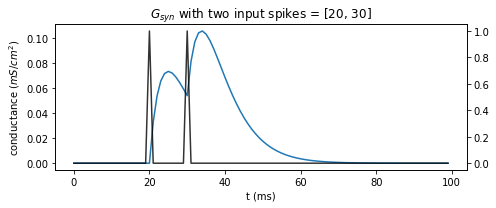

In [10]:
results = []
spikes = [20,30]
for i in range(100):
    results.append(gsyn(i, spikes))

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(results)

ax2 = ax.twinx()
spike_p = np.zeros(100)
spike_p[spikes] += 1
ax2.plot(spike_p,c='k',alpha=0.8,)

ax.set(title="$G_{syn}$ "+f"with two input spikes = {spikes}",
       xlabel="t (ms)",
       ylabel="conductance ($mS/cm^2$)")
fig.tight_layout()
fig.show()

Synaptic excitation run with complex input

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


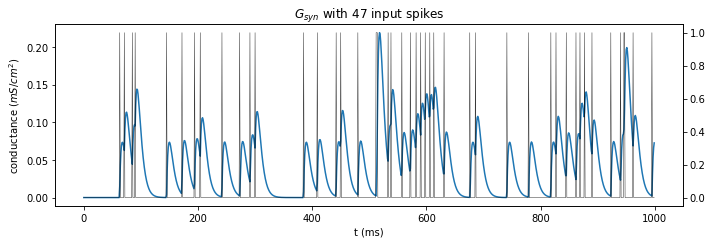

In [11]:
dt=0.001 # 1 ms
d = 1
spikes = spike_train(d, 50, dt)
results = []
for i in range(np.arange(0,d,dt).shape[0]):
    results.append(gsyn(i, spikes))

fig, ax = plt.subplots(figsize=(10,3.5))
ax.plot(results,lw=1.5)

ax2 = ax.twinx()
spike_p = np.zeros(int(d/dt))
spike_p[np.rint(spikes).astype(int)] += 1

ax2.plot(spike_p, c='k',alpha=0.8, lw=0.5)

ax.set(title="$G_{syn}$ "+f"with {spikes.shape[0]} input spikes",
       xlabel="t (ms)",
       ylabel="conductance ($mS/cm^2$)")
fig.tight_layout()
fig.show()

Neuron equations

In [12]:
def minf(V):
    return 1/(1+np.e**(-(V-vmaxm)/km))
def ninf(V):
    return 1/(1+np.e**(-(V-vmaxn)/kn))
def neuron(X, t): 
    
    V = X[0]
    n = X[1]
    
    dVdt = (5 - gl*(V-el) - gna*minf(V)*(V-ena) - gk*n*(V-ek) - gsyn(t, spikes)*(V))/C
    #dVdt = (5 - gl*(V-el) - gna*minf(V)*(V-ena) - gk*n*(V-ek) )/C
    dndt = (ninf(V) - n)/taun
    
    return [dVdt, dndt]


In [13]:
def opt_gsyn(t, train):
    result = 0
    reduced_train = train[(train > (t-40)) & (train < t)]
    for it in reduced_train:
        result += alfa(t-it)*step(t-it)
    return result


Plot V in one neuron

In [14]:
from scipy.integrate import odeint

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


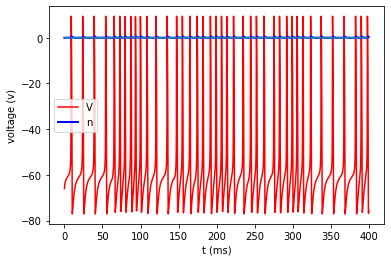

<Figure size 7200x3600 with 0 Axes>

In [15]:
dt=0.001
t = np.arange(0.0, 400.0, dt)
s0=[-66, 0]
out= odeint(neuron, s0, t)


plt.plot(t,out[:,0],'r-', linewidth=1.5)
plt.plot(t,out[:,1],'b-', linewidth=2.0)
plt.plot(results[0:400])

plt.xlabel("t (ms)")
plt.ylabel("voltage (v)")
plt.legend(["V","n"])
plt.figure(figsize=(100,50))
plt.show()

In [16]:
from collections import Counter

In [17]:

def count_peaks(temporal_series, thr):
    # List of values
    values = temporal_series>-thr
    values = values.astype('int')
    # Computes the crossing 1: ascendent -1: descendent
    difference = values[1:]-values[:-1]
    # Count the number of 1 (ascendent crossings)
    peaks = Counter(difference)[1]
    
    return peaks

**3-Study two neuron dynamics**

We explore the synapses modeled using the formalism of voltage-gated ionic channels. Two neurons that are modeled according to the system described bellow.

$$CV'_{i} = I - g_L(V_{i}-E_L)-g_{Na}m_{\infty}(V_{i})(V_{i}-E_{Na})-g_Kn(V-E_K)$$
$$\tau_nn_{i} = n_{\infty}(V_{i})-n_{i}$$

for $i = 1, 2$. Consider that Neuron 1 excites and Neuron 2, and Neuron 2 inhibits and
Neuron 1. This implies that the equation of V1 must contain the term $−g_{inh,max}s_{2}(V_{1} −
E_{inh})$, whereas the equation for $V_{2}$ must contain the term $−g_{exc,maxs}s_{1}(V_{2} − E_{exc})$. 

with $s' = A_{s}f_{pre}(u_{i})(1-s_{i})-\beta_{i}s_{i}, \quad    i=1,2 $

$f_{pre}(u) = 1/(1 + e^{−(u − u_{t})/v_{s}})$

$CV'_{1} = I - g_L(V_{1}-E_L)-g_{Na}m_{\infty}(V_{1})(V_{1}-E_{Na})-g_Kn(V-E_K)−g_{inh,max}s_{2}(V_{1}−
E_{inh})+g_{syn}(t)(V-E_{syn})$

a) Spiking activity f the two neurons for different values of the maximal
inhibitory synaptic conductance $$g_{inh,max} \in \{0,1,2\} mS/cm^2$$

In [18]:
# Global constants

ut, us = 2, 5
As = 1
b1, b2 = 0.25, 0.1
g_exm, g_inhm = 1, 0.1
I1, I2 = 5, 5

# Equations
def fpre(u):
    return 1./(1 + mth.exp((ut-u)/us))

def twoneurons(V, t):
    V1 = V[0]
    V2 = V[1]
    
    n1 = V[2]
    n2 = V[3]
    
    s1 = V[4]
    s2 = V[5]
    #######################################################################
    dV1dt = (I1 - gl*(V1-el) - gna*minf(V1)*(V1-ena) -  gk*n1*(V1-ek) - g_inhm*s2*(V1 - (-80))- opt_gsyn(t, spikes)*(V1))/C # - opt_gsyn(t, results[])*(V1) einh = -80
    dn1dt = (ninf(V1) - n1)/taun
    
    dV2dt = (I2 - gl*(V2-el) - gna*minf(V2)*(V2-ena) - gk*n2*(V2-ek) - g_exm*s1*(V2 - 0))/C # eix = 0
    dn2dt = (ninf(V2) - n2)/taun
    
   
    ds1dt = As * fpre(V1)*(1-s1) - b1*s1
    ds2dt = As * fpre(V2)*(1-s2) - b2*s2
    
    return [dV1dt, dV2dt, dn1dt, dn2dt, ds1dt, ds2dt]
    

Testing Plot $V_{1}(t), V_{2}(t)$ ## This is just for tests. Not to be included at the report.

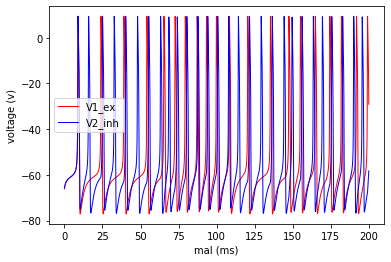

In [35]:
# V response plots for testing
dt=0.001
dur = 200 # duration of simulations from now on
t = np.arange(0.0, dur, dt)
V0 = [-66, -66, 0, 0, 0, 0] # V1, V2, n1, n2, s1, s2

twoneurons(V0, 1)
out = odeint(twoneurons, V0, t)


plt.plot(t,out[:,0],'r-', linewidth=1.0)
plt.plot(t,out[:,1],'b-', linewidth=1.0)
#plt.plot(results[0:200],linewidth=1.5)
plt.xlabel("mal (ms)")
plt.ylabel("voltage (v)")
plt.legend(["V1_ex","V2_inh"])
plt.show()

Plots for $ \ g_{syn}\ $ and $ \ V_{i} , \quad i=1,2\ $ for different values of $ \ g_{inhibitory_max}=0,1,2$.

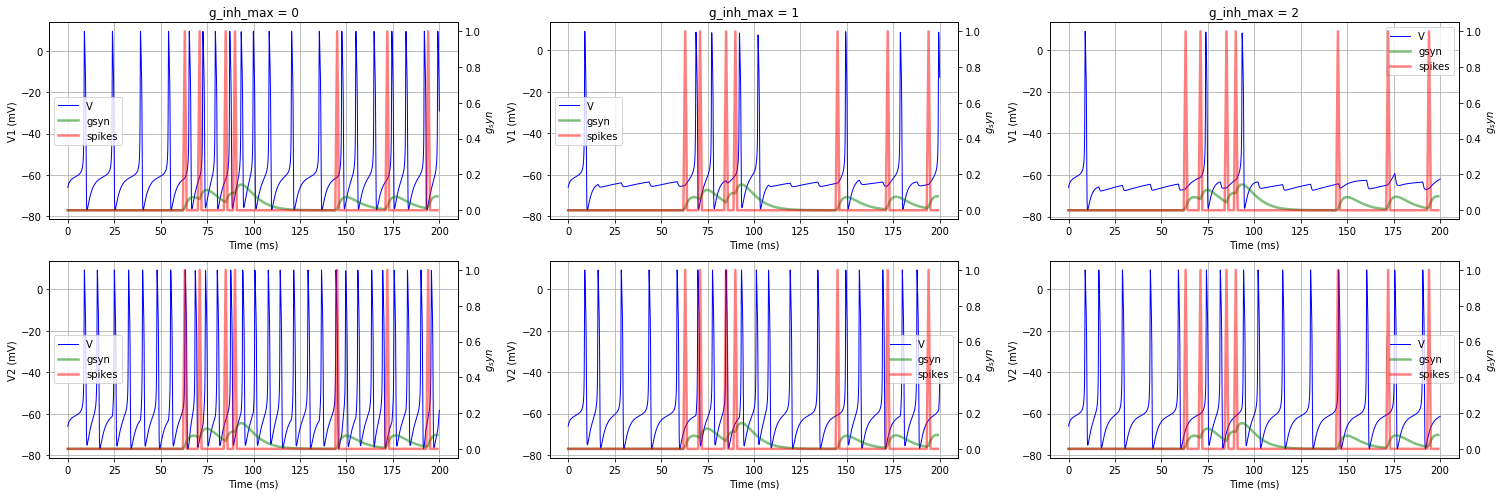

In [36]:
g_in = [0, 1, 2] # different values of g_inhibitory_max, for comparing V1
time_span = t

fig, ax = plt.subplots(2, len(g_in), figsize=(7*len(g_in),7))
for j in range(2):
    for i,param in enumerate(g_in):
            g_inhm = param # for each plot give values g_syn = 0,1,2
            s = odeint(twoneurons, V0, time_span)
            
            # if => just for title select
            if j==0:ax[j][i].set(xlabel='Time (ms)', ylabel='V{} (mV)'.format(j+1),
                     title='g_inh_max = {}'.format(param))
            else: ax[j][i].set(xlabel='Time (ms)', ylabel='V{} (mV)'.format(j+1))
            v = ax[j][i].plot(time_span, s[:,j], color='b', lw=1)
            ax2 = ax[j][i].twinx()
            ax2.set(ylabel="$gsyn$")
            w0 = ax2.plot( results[0:dur], color='g', lw=2.5, alpha=0.5)
            w1 = ax2.plot(spike_p[0:dur], color='r', lw=2.5, alpha=0.5)
        
            ax[j][i].legend([v[0],w0[0],w1[0]],['V'.format(j), 'gsyn (mS/cm^2)', 'spikes'])
            ax[j][i].grid(True)
            fig.savefig('two_neurons_different_g_inhmax')
plt.tight_layout()

g_inhm = 0 # initialization of g_inh_max 

Plots with different values of $\beta_{1}$, $\beta_{2}$ (Probably not correct yet. 2 things: decrease time scale, Maybe the aplitude in $V_{2}$ decreases as time goes by)

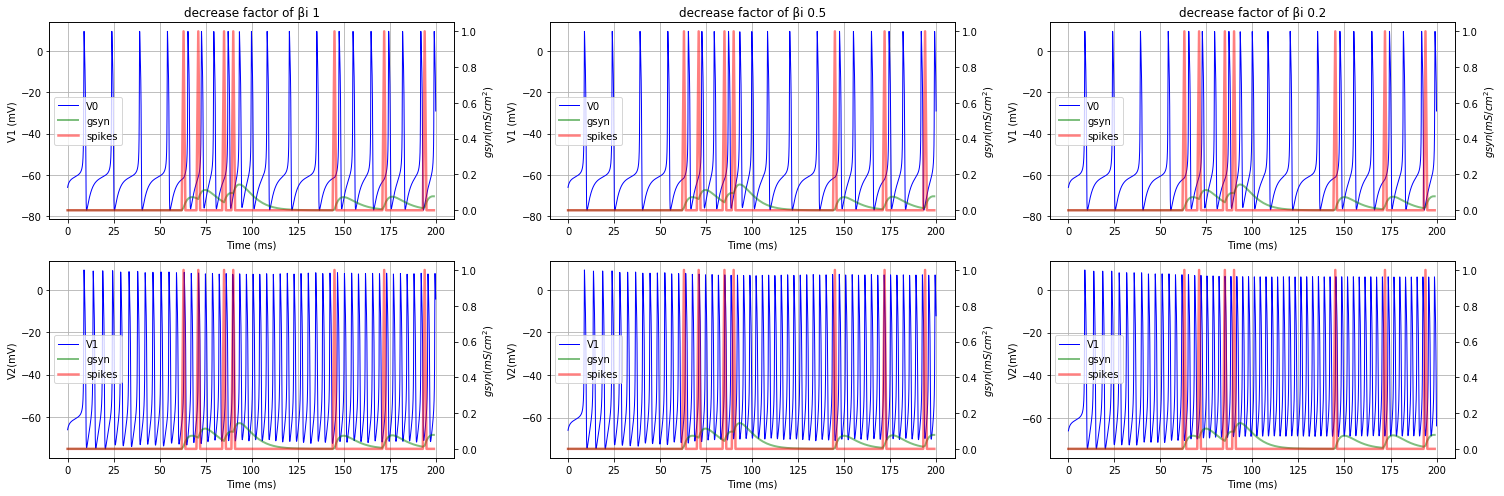

In [38]:
b1, b2 = 0.25, 0.1 # different values of β1, β2 for comparing V1
l = [1, 0.5, 0.1/0.5] # factor to change βi 
time_span = t

fig, ax = plt.subplots(2, len(g_in), figsize=(7*len(g_in),7))
for j in range(2): # for ploting two different neurons' Voltage response
    for i,param in enumerate(l):
            b1 *= param # for each plot give values βi = βi * l
            b2 *= param
            s = odeint(twoneurons, V0, time_span)
           
            # if => just for title select
            if j==0: ax[j][i].set(xlabel='Time (ms)', ylabel='V{} (mV)'.format(j+1), 
                     title='decrease factor of βi {}'.format(param))
            else:  ax[j][i].set(xlabel='Time (ms)', ylabel='V{}(mV)'.format(j+1))
        
            v = ax[j][i].plot(time_span, s[:,j], color='b', lw=1)
            ax2.set(ylabel="$gsyn (mS/cm^2)$")
            ax2 = ax[j][i].twinx()
            w0 = ax2.plot( results[0:dur], color='g', lw=2, alpha=0.5) # g_syn plot
            w1 = ax2.plot( spike_p[0:dur], color='r', lw=2.5, alpha=0.5)# spike plot
            
            ax[j][i].legend([v[0],w0[0],w1[0]],['V{}'.format(j),'gsyn','spikes'])
            ax[j][i].grid(True)
            fig.savefig('two_neurons_different_βi')
plt.tight_layout()

g_inhm = 0 # initialization of g_inh_max 
b1, b2 = 0.25, 0.1 # initialization of β1, β2

In [83]:
###### ΙN PROGRESS #########
dt=0.001
dur = 200 # duration of simulations from now on
time_span = np.arange(0.0, dur, dt)

def my_plot(time, f, g, spks, f_name, g_name, spks_name, title_name):

    fig, ax = plt.subplots(1, figsize=(7,3.5))

    l1, = ax.plot(time_span, f, c='b', label=f_name)
    l2, = ax.plot(time_span, g, c='r', label=g_name)
    
    # Plot spike lines
    for t in spks:
        if t <= dur:
            l3 = ax.axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

    ax.set(title = title_name,
           xlabel = "Time (ms)",
       ylabel=f_name,
       )
    
    ax2 = ax.twinx()
    ax2.set(ylabel= g_name)
    
    ax.grid()

    lines = [l1,l2,l3]
    ax.legend(lines, [l.get_label() for l in lines])

    fig.tight_layout()
    fig.show()

<class 'numpy.ndarray'> 200000
200000 200000 47


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


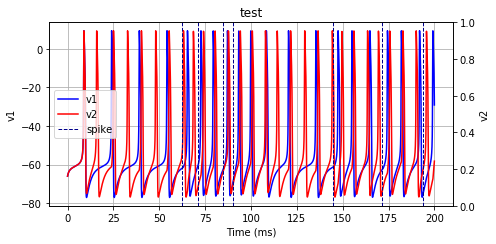

In [84]:
s = odeint(twoneurons, V0, time_span)
print(type(spike_p), int(dur/dt))
print(len(s[:,0]),len(s[:,1]),len(spikes))
my_plot(time_span, s[:,0], s[:,1], spikes, "v1", "v2", "spikes", "test")